# Capstone Project

### General Information

For the project I used data from two API providers, Nasdaq and CryptoCompare. At the end of this cell you can find the links to the specific data sources, as well as to other resources. Both providers also offer a general API documentation on their website. To make API requests easier I definied custom functions in two separate Python scripts "nasdaq.py" and "crypto_compare.py", which I import as modules at the beginning. As the functions in these two scripts use my valid API key which I keep secret you wouldn't be able to use them and therefore you couldn't execute this Notebook. But the functions write all of the queried data to CSV files, which are provided together with all other resources you need to run this Notebook. If you want to use the functions of the Python scripts, you need valid API keys. As I store mine in separate text files (see scripts for more details) the functions read the respective key from the respective file. You can alter it for your usecase. If you want to learn more about the metrics you can visit the websites of Nasdaq and CryptoCompare or look at the PDF file "Additional_Info_BTC_Metrics.pdf" which I uploaded as well.

Data Resources:
- Nasdaq Data Source: https://data.nasdaq.com/databases/BCHAIN
- CryptoCompare Data Source: https://min-api.cryptocompare.com/documentation

Other Resources:
- Bitcoin.png: https://banner2.cleanpng.com/20180811/aea/42726f67cae210141b65d41f85d83733.webp
- Gold.png: https://getdrawings.com/free-icon-bw/gold-bar-icon-10.png

NOTE: If you execute the code all visualizations will be downloaded automatically except the 5th visualization (Bitcoin's market cap compared with Gold's market cap). So if you also want to download this image you should do it manually.

In [1]:
import crypto_compare as cc
import nasdaq as nq
import nasdaqdatalink
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import plotly.express as px
import plotly.graph_objects as go
import time
import requests
import math
from datetime import datetime, timedelta, timezone
from PIL import Image
import plotly.io as pio

In the following cell I executed my custom functions once so the CSV files were created/downloaded. This just works with a valid API key, so as long as you don't have one this cell would print an error. Therefore in commented out the cell after the execution. In the following cell all data is read in from the CSV files which ensures everybody can work with this notebook. 

For the one time I execute my custom functions I query all available Bitcoin paramters/metrics from the API sources. I will not use all of them for this project, so there will be some data cleaning in the beginning. But again, maybe people want to check out some other metrics and they cn do that with all data available in the CSV files.

In [2]:
# Last execution: 2025-01-01 (all data until 2024-12-17)

#nq.get_btc_data()
#cc.get_blockchain_info()
#cc.get_asset_price_data()

In [3]:
# Read in CSV files
nq_btc_data = pd.read_csv('nasdaq-data-BTC.csv', header=0)
cc_btc_data = pd.read_csv('cc-blockchain-info-BTC.csv', header=0)
cc_btc_price_data = pd.read_csv('cc-price-data-BTC.csv', header=0)

# Filter out relevant Bitcoin metrics for this project
nq_btc_data = nq_btc_data[['date', 'TOTBC', 'MKPRU', 'MKTCP', 'HRATE', 'DIFF']]
cc_btc_data = cc_btc_data[['date', 'total_addresses_all_time', 'active_addresses', 'hashrate', 'difficulty', 'current_supply']]

# Merge both data frames on 'date' to one data frame
btc_data = pd.merge(nq_btc_data, cc_btc_data, on='date', how='outer')

### Data Cleaning

In [4]:
# Handling missing price data ('MKPRU') by replacing NaN values in Nasdaq data frame with price data from CryptoCompare
dates_missing_MKPRU = list(cc_btc_price_data[cc_btc_price_data.date.isin(btc_data[btc_data.MKPRU.isna()].date)].date)
values_missing_MKPRU = list(cc_btc_price_data[cc_btc_price_data.date.isin(dates_missing_MKPRU)].close)
dict_missing_MKPRU = dict(zip(dates_missing_MKPRU, values_missing_MKPRU))
for date, price in dict_missing_MKPRU.items():
    index = btc_data.index[btc_data.date==date].item()
    btc_data.loc[index, 'MKPRU'] = price

# Handling missing data in 'TOTBC','HRATE', 'DIFF' by replacing NaN values in Nasdaq data frame with data from CryptoCompare
# Handling missing data in 'MKTCP' by calculating it with BTC in circulation ('TOTBC') multplied with current price ('MKPRU')
btc_data.fillna({'TOTBC': btc_data['current_supply'],
                 'HRATE': btc_data['hashrate'],
                 'DIFF': btc_data['difficulty']}, inplace=True),
btc_data.fillna({'HRATE': 0}, inplace=True)
btc_data.fillna({'MKTCP': btc_data.MKPRU * btc_data.TOTBC}, inplace=True),
btc_data.fillna({'HRATE': 0}, inplace=True)
btc_data.drop(columns=['hashrate', 'difficulty', 'current_supply'], inplace=True)

# Handling missing data in 'total_addresses_all_time' and 'active_addresses'
btc_data['total_addresses_all_time'] = btc_data['total_addresses_all_time'].fillna(0)
btc_data.loc[btc_data[btc_data.active_addresses==0].index, 'active_addresses'] = [985272, 953654]  # Data from Glassnode
#btc_data['active_addresses'] = btc_data['active_addresses'].fillna(0)
btc_data.fillna({'active_addresses': 0}, inplace=True)

# Insert a column with the price array that will be used for the 2nd visualization
btc_log_MKPRU = btc_data['MKPRU'].apply(lambda x: 0.05 if x == 0 else x)
btc_data.insert(3, 'log_MKPRU', btc_log_MKPRU)

# Renaming columns
btc_data.rename(columns={'TOTBC': 'circ_supply',
                 'MKPRU': 'USD_price',
                 'log_MKPRU': 'USD_price_log',
                 'MKTCP': 'market_cap',
                 'HRATE': 'hashrate',
                 'DIFF': 'difficulty',
                 'total_addresses_all_time': 'total_addrs',
                 'active_addresses': 'active_addrs'
                 }, inplace=True)

# Changing dtypes for some columns
btc_data['date'] = pd.to_datetime(btc_data['date'], format='%Y-%m-%d')
btc_data['active_addrs'] = btc_data['active_addrs'].astype(int)

### Layout preparation and function definition

In [5]:
# Color of BTC symbol: 
btc_color = 'rgba(247, 147, 26, 1)'

# Define the layout template: 
base_layout = dict(
    showlegend=False,
    margin=dict(l=80, r=20, t=80, b=50),
    plot_bgcolor="white",
    paper_bgcolor="white",
    title_font=dict(size=30, family="Times New Roman", weight="bold"),
    title=dict(x=0, xref='paper'),
    font=dict(size=18, family="Times New Roman", color="black"),  
    xaxis=dict(
        title=None,
        title_font_size=18,
        tickformat="%Y",   
        tickvals=pd.date_range("2009-01-01", "2025-12-31", freq="YS") + pd.Timedelta(days=182.5),  
    ),
    yaxis=dict(
        title="BTC Price in US$",
        title_font_size=20,
        tickmode='array',
        tickvals=[x for x in range(0, 120000+1, 20000)],
        ticktext=['0', '20,000', '40,000', '60,000', '80,000', '100,000', '120,000'] 
    )
)

In [6]:
def update_hover_template(fig, trace_type="price", trace_index=None):
    """
    Updates the hovertemplate for a specific trace in the figure.

    Parameters:
    - fig: Plotly figure object to update. 
    - trace_type: Metric to update (default = "price").
    - trace_index: Index of the trace to update (default = None, applies to all traces if None).
    """
    if trace_type == "price":
        hover_template = ("<b>Date:</b> %{x|%b %d, %Y}<br>"
                          "<b>Price:</b> %{y:,} USD<br><extra></extra>")
    elif trace_type == "addresses":
        hover_template = ("<b>Date:</b> %{x|%b %d, %Y}<br>"
                          "<b>Address count:</b> %{y:,}<br><extra></extra>")
    elif trace_type == "transactions":
        hover_template = ("<b>Date:</b> %{x|%b %d, %Y}<br>"
                          "<b>Transaction count:</b> %{y:,}<br><extra></extra>")
    elif trace_type == "hashrate":
        hover_template = ("<b>Date:</b> %{x|%b %d, %Y}<br>"
                          "<b>Hashrate:</b> %{y:,}<br><extra></extra>")
    elif trace_type == "difficulty":
        hover_template = ("<b>Date:</b> %{x|%b %d, %Y}<br>"
                          "<b>Difficulty:</b> %{y:,}<br><extra></extra>")
    else:
        raise ValueError("Error: Please enter one of the following trace types: price, addresses, transactions, hashrate, difficulty")
    
    # In case 
    if trace_index is not None:
        # Update only the specified trace using direct access
        fig.data[trace_index].hovertemplate = hover_template
    else:
        # Update all traces
        for trace in fig.data:
            trace.hovertemplate = hover_template

In [7]:
# Define a function to add halvings to charts:
def add_halving_lines(fig, line_color="rgba(0, 0, 0, 0.25)", line_width=2, line_dash="dot", log_chart=False):
    """
    Adds vertical lines for Bitcoin halving dates to a Plotly figure.

    Parameters:
    - fig: The Plotly figure object to which the lines will be added.
    - halving_dates: A list of datetime objects representing the halving dates.
    - line_color: The color of the vertical lines (default is "red").
    - line_width: The width of the vertical lines (default is 2).
    - line_dash: The dash style of the vertical lines (default is "dot").
    - log_chart: Wether the y-axis of fig is logarithmic scale or not (default is "False").
    """
    halving_dates = {
    '1st Halving': '2012-11-28',  
    '2nd Halving':'2016-07-09',   
    '3rd Halving':'2020-05-11',   
    '4th Halving':'2024-04-20'    
    }

    # Adapt the the positions for the halving annotations in case of linear or log scale
    if log_chart == False:
        y_limit = max(fig.data[0]['y'])*1.09
        annotation_y = 116500
    else:
        y_limit = max(fig.data[0]['y'])*5
        annotation_y = 5.745

    for halving_number, halving_date in halving_dates.items():
        # Add halvings as dotted lines
        fig.add_trace(go.Scatter(
            x=[halving_date, halving_date],  
            y=[0, y_limit],  
            mode="lines",
            line=dict(
                color=line_color,
                width=line_width,
                dash=line_dash
            ),
            name=None,
            showlegend=False,  
            hoverinfo="none"
        ))

        fig.add_annotation(
            x=halving_date,      
            y=annotation_y,      
            text=halving_number,
            showarrow=False,     
            font=dict(color="rgba(0, 0, 0, 0.7)", size=17),  
            xref="x",          # Align text horizontally with the line
            yanchor="bottom"   # Align text vertically above the line
        )  

In [8]:
# Define a function to add latest data for specified BTC metric to charts:
def add_latest_data(fig, data_type="price", color="rgba(247, 147, 26, 1)", log_chart=False):
    
    latest_date = fig.data[0]['x'][-1].strftime('%Y-%m-%d')
    latest_value = fig.data[0]['y'][-1]

    if data_type == "price":
        # Add marker for latest price
        fig.add_trace(go.Scatter(
                x=[latest_date],
                y=[latest_value],
                mode="markers",
                marker=dict(
                    color=color,
                    size=6
                ),
                name="",
                showlegend=False, 
                hovertemplate=("<b>Date:</b> %{x|%b %d, %Y}<br>"
                               "<b>Price:</b> %{y:,} USD<br>")
        ))

        if log_chart == False:
            annotation_y_1 = latest_value * 1.045
            annotation_y_2 = latest_value * 0.955
        else:
            # Convert to log10
            annotation_y_1 = math.log10(latest_value * 1.88) 
            annotation_y_2 = math.log10(latest_value * 0.55) 

        # Add annotations for price
        fig.add_annotation(
            x=pd.to_datetime(latest_date) + pd.Timedelta(days=310),      
            y=annotation_y_1,      
            text=f"{latest_date}:",
            showarrow=False,     
            font=dict(color=color, size=18, weight="bold"),  
            xref="x",   # Align text horizontally with the line
            yref="y",   # Align text vertically above the line
            yanchor="middle"
        ) 

        fig.add_annotation(
            x=pd.to_datetime(latest_date) + pd.Timedelta(days=305),      
            y=annotation_y_2,      
            text=f"${latest_value:,}",
            showarrow=False,     
            font=dict(color=color, size=18, weight="bold"),  
            xref="x",   # Align text horizontally with the line
            yref="y",   # Align text vertically above the line
            yanchor="middle"
        )
    
    elif data_type == "total_addresses":
        # Add marker for latest total addresses
        fig.add_trace(go.Scatter(
                x=[latest_date],
                y=[latest_value],
                mode="markers",
                marker=dict(
                    color=color,
                    size=6
                ),
                name="",
                showlegend=False, 
                hovertemplate=("<b>Date:</b> %{x|%b %d, %Y}<br>"
                               "<b>Total Addresses:</b> %{y:,}<br>")
        ))

        annotation_y_1 = latest_value * 1.035
        annotation_y_2 = latest_value * 0.97

        # Add annotations for total addresses
        fig.add_annotation(
            x=pd.to_datetime(latest_date) + pd.Timedelta(days=260),      
            y=annotation_y_1,      
            text=f"{latest_date}:",
            showarrow=False,     
            font=dict(color=color, size=15, weight="bold"),  
            xref="x",   # Align text horizontally with the line
            yref="y",   # Align text vertically above the line
            yanchor="middle"
        ) 

        fig.add_annotation(
            x=pd.to_datetime(latest_date) + pd.Timedelta(days=260),      
            y=annotation_y_2,      
            text=f"{latest_value / 1_000_000_000:.2f} Bil.",                     
            showarrow=False,     
            font=dict(color=color, size=15, weight="bold"),  
            xref="x",   # Align text horizontally with the line
            yref="y",   # Align text vertically above the line
            yanchor="middle"
        )

In [9]:
# Define a function for formatting the y axis labels of the last two visualizations (hashrate and difficulty):
def format_ticks(value, fixed_power=None):
    if value == 0:
        return "0"
    if fixed_power is not None:
        coeff = value / 10**fixed_power
        return f"{coeff:.1f}⋅10<sup>{fixed_power}</sup>"
    power = int(np.floor(np.log10(value)))
    coeff = value / 10**power
    return f"{coeff:.1f}⋅10<sup>{power}</sup>"

### 1st Visualization: Linear Price Chart

**Goal:** Show the price history with ralies and corrections over time.

In [10]:
# Create the plot
fig1 = px.line(
    btc_data,
    x="date",
    y="USD_price",
    title="<span style='color:rgba(247, 147, 26, 1);'>The linear BTC price chart shows the volatility of the young asset</span><br>"
          "<sup><span style='color:rgba(0, 0, 0, 0.5);'>Major price increases after the halvings were followed by significant downside moves</span></sup>",
    color_discrete_sequence=[btc_color]
)

fig1.update_traces(line=dict(width=2))

# Customize layout 
fig1.update_layout(**base_layout)
update_hover_template(fig=fig1)
add_halving_lines(fig=fig1)
add_latest_data(fig=fig1)

pio.write_image(fig=fig1, file='fig1.png', scale=3.5, width=1206, height=450)
fig1.show()

### 2nd Visualization: Logarithmic Price Chart

**Goal:** Show the price history but with less volatility noise. As Bitcoin is still a young a relatively small asset (in comparison to other traditional assets), volatility is normal but can distort the perception.

In [11]:
# Create the plot
fig2 = px.line(
    btc_data,
    x="date",
    y="USD_price_log",
    log_y=True,
    title="<span style='color:rgba(247, 147, 26, 1);'>The logarithmic price chart shows Bitcoin's value appreciation with less volatility</span><br>"
          "<sup><span style='color:rgba(0, 0, 0, 0.5);'>Log charts treat percentage price movements equally," 
          " which is more useful for long term price analysis</span></sup>",
    color_discrete_sequence=[btc_color]
)

fig2.update_traces(line=dict(width=2))

# Customize layout to match the first visualization:
fig2.update_layout(**base_layout)
update_hover_template(fig=fig2)
#add_halving_lines(fig=fig2, log_chart=True) # if halving lines are wanted, just uncomment the code
add_latest_data(fig=fig2, log_chart=True)

# Update y-axis manually because log(0) is not defined
fig2.update_layout(
    yaxis=dict(
        range=(-1.4, 6.5),
        tickmode='array',
        tickvals=[0.05, 1, 10, 100, 1000, 10000, 100000, 1000000],
        ticktext=['0', '1', '10', '100', '1000', '10,000', '100,000', '1,000,000'] 
    )
)

pio.write_image(fig=fig2, file='fig2.png', scale=3.5, width=1206, height=450)
fig2.show()

### 3rd and 4th Visualization: Total Number of Adresses and Active Addresses 

- Total Number of Addresses: For each day the total number of adresses on the Bitcoin blockchain. 

- Active Addresses: For each day the unique number of addresses that executed at least one transaction during this day.

**Goal:** Show that the total number of addresses on the Bitcoin Blockchain is steadily increasing, which is a good indicator for a growing network. However the unique addresses that execute a transaction on a given day are not increasing in the same way. This could indicate that even if Bitcoiin gets more popular, many people don't use it as a daily payment system but more as a longer term investment or store of value.

In [12]:
# Create the plot
fig3 = go.Figure()

fig3.add_trace(go.Scatter(
    x=btc_data['date'],
    y=btc_data['total_addrs'],
    line=dict(color=btc_color, width=3),
    mode='lines',
    name="Total Addresses"
))
update_hover_template(fig3, trace_type="addresses")

fig3.update_layout(
    base_layout,
    title={'text': "<span style='color:rgba(247, 147, 26, 1);'>The total number of Bitcoin addresses is on a steady increase</span>"},
    xaxis=dict(
        range=["2009-01-01", "2025-12-31"],
        title=None,
        title_font_size=18,
        tickformat="%Y",
        tickvals=pd.date_range("2009-01-01", "2025-12-31", freq="YS") + pd.Timedelta(days=182.5)
    ),
    yaxis=dict(
        title="Total Number of Addresses",
        title_font_size=20,
        tickfont=dict(color=btc_color),
        titlefont=dict(color=btc_color),
        linecolor=btc_color,
        tickcolor=btc_color,
        linewidth=1.5,
        showline=True,
        ticks='outside',
        side='left',
        tickmode='array',
        range=[0, btc_data['total_addrs'].max() * 1.1],
        tickvals=[x for x in range(0, 1400000000 + 1, 200000000)],
        ticktext=['0', '0.2 Bil.', '0.4 Bil.', '0.6 Bil.', '0.8 Bil.', '1.0 Bil.', '1.2 Bil.', '1.4 Bil.']
    )
)

add_latest_data(fig=fig3, data_type="total_addresses")

# Save and display the first figure
pio.write_image(fig=fig3, file='fig3.png', scale=3.5, width=1206, height=450)
fig3.show()

In [13]:
# Create plot
fig4 = go.Figure()

fig4.add_trace(go.Scatter(
    x=btc_data['date'],
    y=btc_data['active_addrs'],
    line=dict(color="rgba(0, 0, 0, 0.3)", width=1),
    mode='lines',
    name="Active Addresses"
))
update_hover_template(fig4, trace_type="transactions")

fig4.update_layout(
    base_layout,
    title={'text': "<span style='color:rgba(0, 0, 0, 0.5);'>But not all addresses are active on a daily basis</span>"},
    xaxis=dict(
        range=["2009-01-01", "2025-12-31"],
        title=None,
        title_font_size=18,
        tickformat="%Y",
        tickvals=pd.date_range("2009-01-01", "2025-12-31", freq="YS") + pd.Timedelta(days=182.5)
    ),
    yaxis=dict(
        title="Active Addresses",
        title_font_size=20,
        tickfont=dict(color="rgba(0, 0, 0, 0.9)"),
        titlefont=dict(color="rgba(0, 0, 0, 0.9)"),
        linecolor="rgba(0, 0, 0, 0.5)",
        tickcolor="rgba(0, 0, 0, 1)",
        linewidth=1.5,
        showline=True,
        ticks='outside',
        side='left',
        tickmode='array',
        range=[0, btc_data['active_addrs'].max() * 1.1],
        tickvals=[x for x in range(0, 1400000 + 1, 200000)],
        ticktext=['0', '0.2 Mil.', '0.4 Mil.', '0.6 Mil.', '0.8 Mil.', '1.0 Mil.', '1.2 Mil.', '1.4 Mil.']
    )
)

# Save and display the second figure
pio.write_image(fig=fig4, file='fig4.png', scale=3.5, width=1206, height=450)
fig4.show()


### 5th Visualization: Comparison with Gold Market Cap

**Goal:** Comparing the market cap of Bitcoin with the marketcap of Gold by a visualization with squares. Each square represents a value of ~1.8 Trillion USD, which is Bitcoin's current market cap (2024 Dec 31th). At the same time Gold has a market cap of ~18 Trillion USD, so 10 times the market cap of Bitcoin. Or in other words: Bitcoin's market cap is 1/10 the market cap of Gold. Therefore I created 10 squares (representing the market cap of Gold) of which just one is orange (representing the market cap of Bitcoin).

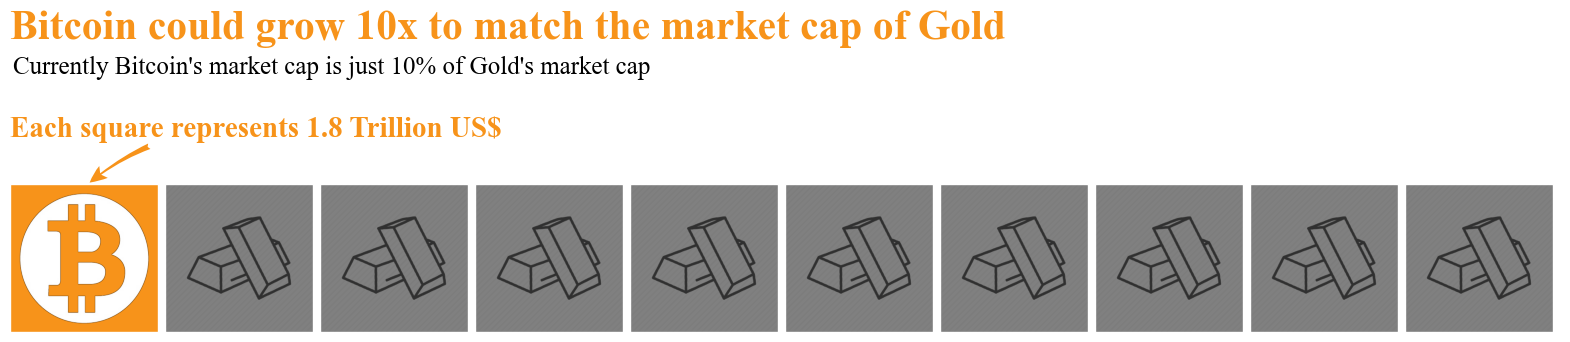

In [14]:
# Define the arangement, size and gap between squares
rows = 1
cols = 10
square_size = 4  
spacing = 0.2    
fig5, ax = plt.subplots(figsize=(20, 16))

# Calculate the offsets for centering in the figure
rect_x_start = -cols * (square_size + spacing) / 2 + spacing / 2
rect_y_start = -rows * (square_size + spacing) / 2 + spacing / 2

btc_color = (247 / 255, 147 / 255, 26 / 255, 1) # define btc_color for matplotlib

# Draw the 20 squares with spacing
for i in range(rows):
    for j in range(cols):
        color = btc_color if (i == rows - 1 and j == 0) else 'grey'
        square = patches.Rectangle(
            (j * (square_size + spacing), i * (square_size + spacing)), 
            square_size, square_size, 
            edgecolor='white', facecolor=color
        )
        ax.add_patch(square)

        if color == btc_color:
            # Add Bitcoin symbol to the orange square
            btc_image = Image.open("Bitcoin.png")
            btc_x = j * (square_size + spacing)
            btc_y = i * (square_size + spacing)
            ax.imshow(
                btc_image, 
                extent=(btc_x+0.06, btc_x + square_size-0.04, btc_y+0.03, btc_y + square_size-0.05), 
                aspect='auto', zorder=10
                )
        else:
            # Add Gold symbol to the grey squares
            gold_image = Image.open("Gold.png")
            gold_x = j * (square_size + spacing)
            gold_y = i * (square_size + spacing)
            ax.imshow(
                gold_image, 
                extent=(gold_x, gold_x + square_size, gold_y, gold_y + square_size), 
                aspect='auto', zorder=10
                )

# Set limits and aspect ratio
ax.set_xlim(0, cols * (square_size + spacing))
ax.set_ylim(0, rows * (square_size + spacing))
ax.set_aspect('equal')

# Remove axes and ticks and set title
ax.axis('off')
ax.set_title("Bitcoin could grow 10x to match the market cap of Gold",
    fontsize=30, pad=100, color=btc_color, loc='left', family='Times New Roman', weight="bold"
)
fig5.suptitle("Currently Bitcoin's market cap is just 10% of Gold's market cap", 
              family="Times New Roman", fontsize=18, x=0.286, y=0.619)  # y controls the vertical position

# Add annotation to the Bitcoin square
ax.annotate(
    "Each square represents 1.8 Trillion US$", 
    xy=(2.1, 4), 
    xytext=(0, 5.3),  
    arrowprops=dict(facecolor=btc_color, 
                    edgecolor=None,
                    arrowstyle="fancy, head_length=0.6, head_width=0.5, tail_width=0.2",
                    connectionstyle="arc3,rad=0.2",
                    linewidth=0),
    fontsize=21, font="Times New Roman", color=btc_color, ha="left", weight="bold"
)

btc_color = 'rgba(247, 147, 26, 1)' # define btc_color as it was before
plt.show()

### 6th Visualization: Circulating Supply of BTC

**Goal:** Showing that 94.3 % of all Bitcoin that will ever exist are already in circulation. The visualization should represent a loading bar with a well advanced loading progress.

In [15]:
# Define Bitcoin supply data
total_supply = 21_000_000  # Fixed supply in BTC
circulating_supply = float(btc_data.iloc[-1]["circ_supply"])  # Current circulating BTC
circulating_supply_date = btc_data.iloc[-1]["date"].strftime('%Y-%m-%d')
num_segments = 20  
segment_width = total_supply / num_segments 
partial_width = (circulating_supply % 1_000_000) / 1_000_000 * segment_width  

# Create the plot and define the gap between rectangles
fig6 = go.Figure()
gap = 0.02 * segment_width  

# Add the fixed grey rectangle for the progress bar background
fig6.add_trace(go.Scatter(
    x=[0, num_segments * segment_width + (num_segments + 1) * gap, num_segments * segment_width + (num_segments + 1) * gap, 0],
    y=[0, 0, 1, 1],  
    fill="toself",
    fillcolor="lightgray",
    line=dict(width=0),  
    mode="lines",
    showlegend=False,
    hovertemplate="Weeks"
))

segment_width=segment_width*0.93

for i in range(num_segments):
    start_x = 0.003*total_supply + i * (segment_width + gap) + gap  # Start each rectangle with a gap
    end_x = start_x + segment_width - 2 * gap  # Reduce width for gaps

    if (start_x - 0.003 * total_supply) + segment_width >= circulating_supply:
        # Use partial width for the last rectangle
        end_x = start_x + partial_width - 2 * gap

    if (start_x - 0.003 * total_supply) >= circulating_supply:
        break  # Stop when exceeding circulating supply

    # Add the orange rectangle
    fig6.add_trace(go.Scatter(
        x=[start_x, end_x, end_x, start_x],
        y=[0.05, 0.05, 0.95, 0.95],  
        fill="toself",
        fillcolor=btc_color, 
        line=dict(width=0),
        mode="lines",
        showlegend=False
    ))

    # Add the Bitcoin symbol in the center of each rectangle  
    fig6.add_layout_image(
        dict(
            source="Bitcoin.png",  
            x=(start_x + end_x) / 2 ,
            y=0.5,  
            xref="x",
            yref="y",
            sizex=segment_width * 0.7,  
            sizey=0.7,  
            xanchor="center",
            yanchor="middle",
            layer="above"
        )
    )

# Add text above the bar for loading information
fig6_loading_text1 = (
    f"Mining in Progress...<br>"
)
fig6.add_trace(go.Scatter(
    x=[total_supply / 2],  
    y=[1.2],  
    text=[fig6_loading_text1],
    mode="text",
    textfont=dict(size=24, color=btc_color, weight="bold"),
    showlegend=False
))

# Add text under the bar for circulating supply information in percentage
fig6_loading_text2 = (
    f"Current status: {(circulating_supply/total_supply) * 100:.1f} % of all Bitcoin in circulation<br>"
)
fig6.add_trace(go.Scatter(
    x=[total_supply / 2],  
    y=[-0.8],  
    text=[fig6_loading_text2],
    mode="text",
    textfont=dict(size=24, color=btc_color, weight="bold"),
    showlegend=False
))

# Add a transparent dummy trace over the whole figure for hover information
fig6.add_trace(go.Scatter(
    x=[0, total_supply, total_supply, 0],  
    y=[-2, -2, 3, 3],  
    fill="toself",  
    fillcolor="rgba(0, 0, 0, 0)",  # Fully transparent fill so just hoverdata is visible
    line=dict(width=0),  
    mode="lines",  
    hoverinfo="text",  
    text=(f"<b>Date:</b> {circulating_supply_date}<br>"
          "<b>Total Supply:</b> 21,000,000 BTC<br>"
          f"<b>Circulating Supply:</b> {circulating_supply:,.0f} BTC<br>"
          f"<b>Percentage Circulated:</b> {(circulating_supply / total_supply) * 100:.1f} %<br>"),
    showlegend=False
))

# Update layout to ensure the entire progress bar fits
fig6.update_layout(
    base_layout,
    xaxis=dict(
        visible=False,
        range=[0, total_supply],  
    ),
    yaxis=dict(
        visible=False,
        range=[-2, 3],  
    ),
    height=300,  
    width=1000,  
    margin=dict(t=10, b=10, l=20, r=20),
    hoverlabel=dict(bgcolor=btc_color)
)

pio.write_image(fig=fig6, file='fig6.png', scale=3.5, width=1000, height=300)
fig6.show()

### 7th and 8th Visualization: Hashrate and Difficulty in one chart

- Hashrate: Total Comptational Power used by miners to process transactions and secure the Bitcoin network. A higher hashrate indicates a more secure network, as more computational power is needed to attack it.

- Difficulty: A measure of how hard it is to mine a new block on the Bitcoin network. Ensures consistent block production every 10 minutes despite changes in the network’s hashrate, because the network recalibrates the difficulty from alone every 2016 blocks (~2 weeks). It is a dimensionless number and a relative measure compared to the difficulty of mining the genesis block, which was set to 1.

**Goal:** Showing that a higher hashrate leads to a higher difficulty, thus making the network more secure over time.

As Bitcoin grows in popularity and its price appreciates, it becomes more attractive both to legitimate miners and to potential attackers. However, the increasing participation of well-intentioned miners strengthens the network's security. The more computational resources are dedicated to mining and transaction validation, the higher the hashrate becomes, making Bitcoin more secure as it grows.

A higher hashrate increases the cost and complexity of attacking the network. This is because Bitcoin’s protocol adjusts the mining difficulty to ensure that a new block is mined approximately every 10 minutes. When computational power increases, the network automatically raises the difficulty, making it harder to mine a block. This higher difficulty translates to increased costs for attackers, as more energy and hardware are required, thereby reducing the attractiveness of attempting an attack.

In [16]:
# Create the Hashrate plot
fig7 = go.Figure()

fig7.add_trace(go.Scatter(
    x=btc_data['date'],
    y=btc_data['hashrate'],
    line=dict(color=btc_color, width=0.7),
    mode='lines'
))
update_hover_template(fig7, trace_type="hashrate")

# Define tick values for the y axis
num_labels = 7  
y_max = 12 * 10**8
y_tickvals = np.linspace(0, y_max, num_labels)  

# Update layout for Hashrate
fig7.update_layout(
    base_layout,
    title={'text': "<span style='color:rgba(247, 147, 26, 1);'>An increasing hashrate indicates network growth and security</span>"},
    xaxis=dict(
        range=["2009-01-01", "2025-12-31"],
        title=None,
        title_font_size=18,
        tickformat="%Y",
        tickvals=pd.date_range("2009-01-01", "2025-12-31", freq="YS") + pd.Timedelta(days=182.5)
    ),
    yaxis=dict(
        title="Hashrate in TH/s",
        title_font_size=18,
        tickfont=dict(color=btc_color),
        titlefont=dict(color=btc_color),
        linecolor=btc_color,
        tickcolor=btc_color,
        linewidth=1,
        showline=True,
        ticks='outside',
        tickmode='array',
        range=[0, y_max],  
        tickvals=y_tickvals,  
        ticktext=[format_ticks(x, fixed_power=8) for x in y_tickvals]
    ),
    hovermode='closest'
)

pio.write_image(fig=fig7, file='fig7.png', scale=3.5, width=1206, height=450)
fig7.show()


In [17]:
# Create the Mining Difficulty plot
fig8 = go.Figure()

fig8.add_trace(go.Scatter(
    x=btc_data['date'],
    y=btc_data['difficulty'],
    line=dict(color="rgba(0, 0, 0, 0.5)", width=2),
    mode='lines'
))
update_hover_template(fig8, trace_type="difficulty")

# Define tick values for the left axis
num_labels = 7  
y_max = 1.2 * 10**14  
y_tickvals = np.linspace(0, y_max, num_labels)  

# Update layout for Mining Difficulty
fig8.update_layout(
    base_layout,
    title={'text': "<span style='color:rgba(0, 0, 0, 0.5);'>The mining difficulty adapts to the growing hashrate every 2016 blocks</span>"},
    xaxis=dict(
        range=["2009-01-01", "2025-12-31"],
        title=None,
        title_font_size=18,
        tickformat="%Y",
        tickvals=pd.date_range("2009-01-01", "2025-12-31", freq="YS") + pd.Timedelta(days=182.5)
    ),
    yaxis=dict(
        title="Mining Difficulty",
        title_font_size=18,
        tickfont=dict(color="rgba(0, 0, 0, 0.9)"),
        titlefont=dict(color="rgba(0, 0, 0, 0.9)"),
        linecolor='rgba(0, 0, 0, 0.5)',
        tickcolor="rgba(0, 0, 0, 1)",
        linewidth=1,
        side="left",
        showline=True,
        ticks='outside',
        tickmode='array',
        range=[0, y_max],
        tickvals=y_tickvals,
        ticktext=[format_ticks(x, fixed_power=14) for x in y_tickvals]
    ),
    hovermode='closest'
)

pio.write_image(fig=fig8, file='fig8.png', scale=3.5, width=1206, height=450)
fig8.show()